In [2]:
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform

In [4]:
label_dataset = rasterio.open('/deep_data/landcover_reproject.tif')
label_image = label_dataset.read()

landsat_dataset = rasterio.open('/deep_data/LC08_CU_028012_20140814_20171017_C01_V01_SR/combined.tif')


In [5]:
# What is the raster's projection?
image_proj = landsat_dataset.crs # 4326
print('Image projection:')
print(image_proj)

# What is the raster's projection?
label_proj = label_dataset.crs
print('Labels projection:')
print(label_proj)

Image projection:
PROJCS["Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.2569999999957,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Labels projection:
EPSG:32618


### Data Generator

In [10]:
inProj = Proj(landsat_dataset.crs)
outProj = Proj(label_dataset.crs)

In [11]:
inProj

pyproj.Proj('+lat_0=23 +lon_0=-96 +y_0=0 +proj=aea +x_0=0 +lat_2=45.5 +lat_1=29.5 +datum=WGS84 +units=m +no_defs=True ', preserve_units=True)

In [12]:
outProj

pyproj.Proj('+units=m +init=epsg:32618 ', preserve_units=True)

In [13]:
training_img_list = []
training_label_list = []

# dataset = input image
# label_image = image w colors
# tile height/width 
# stride = 1
# 

def tile_generator(image_dataset, label_dataset, tile_height, tile_width, batch_size, stride=1):
    img_height, img_width = image_dataset.shape
    label_image = label_dataset.read()
    label_image[label_image == 255] = 1

    c = r = 0
    b = 0

    inProj = Proj(image_dataset.crs)
    outProj = Proj(label_dataset.crs)

    band_count = image_dataset.count
    class_count = len(np.unique(label_image))
  
    while True:
        # potentially don't want to go in order because that means you're not training the network randomly
        # so you might want to just sample randomly from the label_dataset
        for r in range(0, img_height - tile_height+1, stride):
            for c in range(0, img_width-tile_width+1, stride):
                image_batch = np.zeros((batch_size, tile_height, tile_width, band_count))
                label_batch = np.zeros((batch_size,class_count))
                while b < batch_size:
                    tile = image_dataset.read(list(np.arange(1, band_count+1)), window=Window(c, r, tile_width, tile_height))
                    tile = adjust_band(tile)
                    if np.amax(tile) == 0: # don't include if it is part of the image with no pixels
                        pass
                    else:
                        # reshape from raster format to image format
                        reshaped_tile = reshape_as_image(tile)
                        middle_pixel_r = r + np.ceil(tile_width/2)
                        middle_pixel_c = c + np.ceil(tile_height/2)

                        # find gps of that pixel within the image
                        (x, y) = image_dataset.xy(middle_pixel_r, middle_pixel_c)
                        
                        print(middle_pixel_r, middle_pixel_c)
                        print(x, y)

                        # convert the point we're sampling from to the same projection as the label dataset if necessary
                        if inProj != outProj:
                            x,y = transform(inProj,outProj,x,y)
                            
                        print(x, y)

                        # reference gps in label_image
                        row, col = label_dataset.index(x,y)

                        # find label
                        label = label_image[:, row, col]
                        if label == 0:
                            pass

                        else:
                            # add label to the batch in a one hot encoding style
                            label_batch[b][label] = 1
                            image_batch[b] = reshaped_tile
                            b += 1
                yield (image_batch, label_batch)
              

In [14]:
im_batch = None

count = 0
for (im, label) in tile_generator(landsat_dataset, label_dataset, 11, 11, 1):
    if count == 1:
        break
    print('Image')
    print(im.shape)
    print(type(im))
    #print(im)
    print('Label')
    print(label)
    print(label.shape)
    print(type(label))
    print('----')
    count += 1
    im_batch = im

6.0 6.0
1634610.0 1514610.0
248451.80630749816 3906782.947589485
Image
(1, 11, 11, 7)
<class 'numpy.ndarray'>
Label
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(1, 23)
<class 'numpy.ndarray'>
----


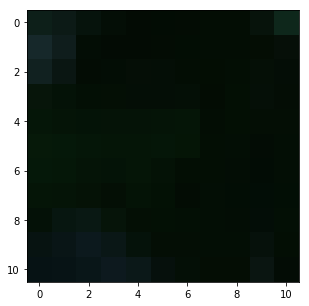

In [22]:
fig, axs = plt.subplots(1, 1, figsize=(18, 5)) 

axs.imshow(im_batch[0,:,:,1:4])

In [23]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [31]:
batch_size = 20
label_image[label_image == 255] = 1
num_classes = len(np.unique(label_image))
epochs = 15

# input image dimensions
img_rows, img_cols = 11, 11
img_bands = landsat_dataset.count

input_shape = (img_rows, img_cols, img_bands)
print(input_shape)

(11, 11, 7)


In [34]:
model = Sequential()
model.add(Conv2D(11, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(22, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(44, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 9, 9, 11)          704       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 22)          2200      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 22)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 3, 3, 22)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 198)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 44)                8756      
_________________________________________________________________
dropout_8 (Dropout)          (None, 44)                0         
__________

In [ ]:
optimizer=keras.optimizers.Adadelta(),
metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))